In [1]:
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
import h5py
import numpy
import pandas
from astropy import units
from galpy.util import bovy_coords, bovy_plot
import gaia_tools.load as gload
import gaia_tools.xmatch
from gaia_tools import query
import matplotlib.colors as mcolors

from misc import bootstrap
%pylab inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Populating the interactive namespace from numpy and matplotlib


# Median Vertical Velocities

This is modified from Morgan Bennett's VWwaves-GaiaDR2, https://github.com/morganb-phys/VWaves-GaiaDR2, VerticalVelocities.ipynb

Read BB19_RVS-result.fits from Gaia Arichive, and create an input file for WendyM2M. 

First, we set the vertical velocity of the Sun. 

In [2]:
vsun= 7.25

## Using the *Gaia* DR2 RV sample


Load the data from BB19_RVS-result.fits.

In [3]:
input_file = './BB19_RVS-result.fits'
star_hdus = pyfits.open(input_file)
out = star_hdus[1].data
star_hdus.close()

# number of stars
nstar = len(out['radial_velocity'])
print('total number of start=', nstar)

total number of start= 6376803


Convert coordinates:

In [4]:
lb= bovy_coords.radec_to_lb(array(out['ra']),array(out['dec']),degree=True)
XYZ= bovy_coords.lbd_to_XYZ(lb[:,0],lb[:,1],1./out['parallax'],degree=True)
Rxy= numpy.sqrt(XYZ[:,0]**2.+XYZ[:,1]**2.)
pmllbb= bovy_coords.pmrapmdec_to_pmllpmbb(out['pmra'],out['pmdec'],
                                         out['ra'],out['dec'],degree=True)
UVW= bovy_coords.vrpmllpmbb_to_vxvyvz(out['radial_velocity'],pmllbb[:,0],pmllbb[:,1],
                                      lb[:,0],lb[:,1],1./out['parallax'],degree=True)

Only keep stars within 250 pc projected onto the plane:

In [5]:
print(' total number of stars=',len(Rxy))
indx= (Rxy < .25)
#Only keep stars within 500 pc projected onto the plane and good parallaxes:
print(' number of stars within the cylinder of Rxy<250pc=',np.size(out['parallax'][indx]))

 total number of stars= 6376803
 number of stars within the cylinder of Rxy<250pc= 864268


Plot x-y and x-z and save the information to hdf5 file.

 output filename= gdr2_bb18_vz.h5


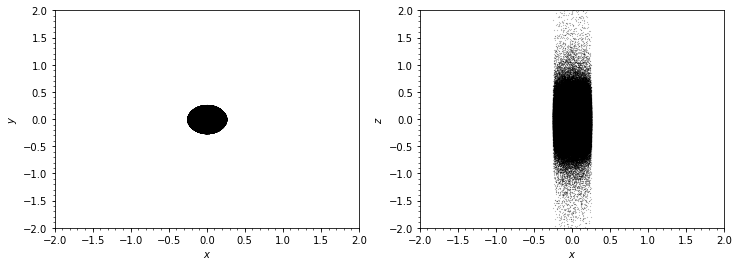

In [6]:
# plot x-y, x-z
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(XYZ[indx,0],XYZ[indx,1],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[-2.0, 2.0],yrange=[-2.0,2.0],gcf=True, markersize=0.1)
subplot(1,2,2)
bovy_plot.bovy_plot(XYZ[indx,0],XYZ[indx,2],'ko', 0.1,
                   xlabel=r'$x$',ylabel=r'$z$',
                   xrange=[-2.0, 2.0],yrange=[-2.0,2.0],gcf=True, markersize=0.1)
# output h5py file
filename='gdr2_bb18_vz.h5'
print(' output filename=', filename)
# writing position data
with h5py.File(filename, 'w') as f:
        f.create_dataset('x',data=XYZ[indx,0])
        f.create_dataset('y',data=XYZ[indx,1])
        f.create_dataset('z',data=XYZ[indx,2])
        f.create_dataset('vz',data=UVW[indx,2])

Let's plot z vs. vz.

 number of stars within the cylinder of Rxy<250pc and Verr<5= 451316
/Users/dkawata/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)



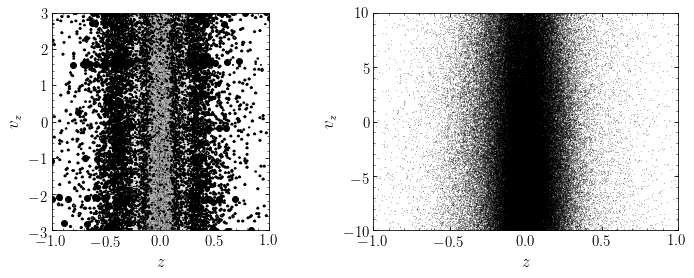

In [7]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
indxverr= ((Rxy < .25) & (out['radial_velocity_error']<1.0))
print(' number of stars within the cylinder of Rxy<250pc and Verr<5=',np.size(out['parallax'][indxverr]))
zpos = XYZ[indxverr,2]
vzvel = UVW[indxverr,2]
bovy_plot.scatterplot(zpos,vzvel,'ko',
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-1.0, 1.0],yrange=[-3.0,3.0],gcf=True)
subplot(1,2,2)
# only plot 20% of data
# rnum = numpy.random.rand(len(z_mock))
# z01 = z_mock[rnum<1.0]
# vz01 = vz_mock[rnum<1.0]
bovy_plot.bovy_plot(zpos,vzvel,'ko', 0.1,
                   xlabel=r'$z$',ylabel=r'$v_z$',
                   xrange=[-1.0, 1.0],yrange=[-10.0,10.0],gcf=True, markersize=0.1)

The vertical (W) velocities and their running median are:

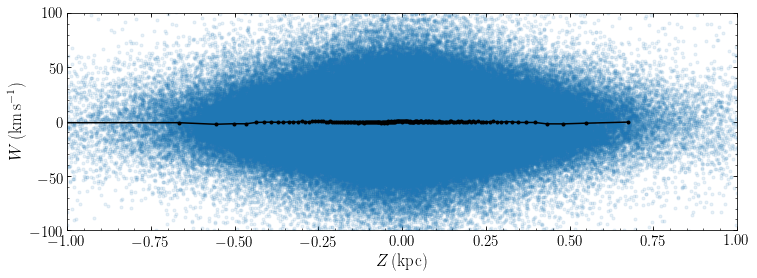

In [8]:
bovy_plot.bovy_plot(XYZ[indx,2],UVW[indx,2]+vsun,'.',alpha=0.1,
                   xrange=[-1.,1.],
                   yrange=[-100.,100.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')   
sindx= numpy.argsort(XYZ[indx,2])
wind= 5000
showskip= wind
running_median_gaia= pandas.DataFrame(UVW[indx,2][sindx]+vsun)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: numpy.nanmedian(x),raw=True)
plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
     'k.-')

Estimate the uncertainty:

In [9]:
running_median_err_gaia= pandas.DataFrame(UVW[indx,2][sindx]+vsun)\
        .rolling(window=wind,center=True,min_periods=wind//2)\
        .apply(lambda x: 1.4826*numpy.nanmedian(numpy.fabs(x-numpy.nanmedian(x)))
                               /numpy.sqrt(numpy.sum(True^numpy.isnan(x))))

/Users/dkawata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until



The median vertical velocity vs. Z:

<ErrorbarContainer object of 3 artists>

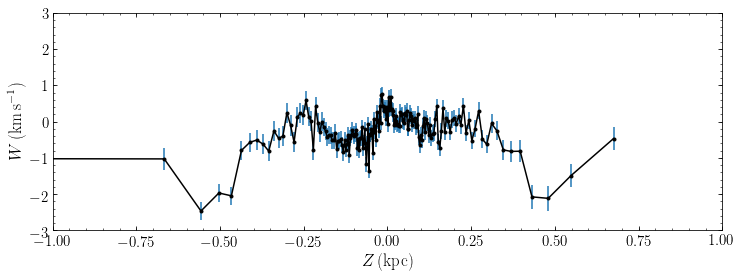

In [10]:
bovy_plot.bovy_plot(XYZ[indx,2][sindx][::showskip],running_median_gaia[::showskip],
                    'k.-',
                    xrange=[-1.,1.],
                    yrange=[-3.,3.],
                   xlabel=r'$Z\,(\mathrm{kpc})$',
                   ylabel=r'$W\,(\mathrm{km\,s}^{-1})$')                    
errorbar(XYZ[indx,2][sindx][::showskip],numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')

Gaia RV sample on a colour-magnitude diagram:

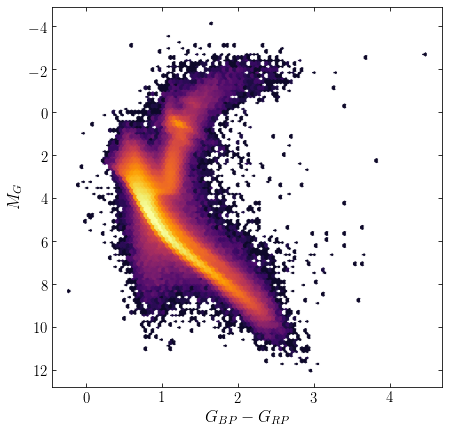

In [26]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(7,7)

colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

MG= -5*log(1000/out['parallax'])/log(10)+5+out['phot_g_mean_mag']
hexbin(out['bp_rp'][indx],MG[indx],bins='log',cmap=cmap)

xlabel(r'$G_{BP}-G_{RP}$')
ylabel(r'$M_G$')

gca().invert_yaxis()

Plot and save the median vertical velocity vs. Z binned by different heights:

In [ ]:
binw1= 0.025
binw2= 0.1
bins= append(append(numpy.round(arange(-1.5,-0.5,binw2),2),
                    numpy.round(arange(-0.5,0.5+binw1,binw1),3)),
             numpy.round(arange(0.5+binw2,1.5+binw2,binw2),2))

vave= zeros(len(bins)-1)
vave_b= zeros(len(bins)-1)
sig= zeros(len(bins)-1)
sig_b= zeros(len(bins)-1)

for i in range(len(bins)-1):
    sample= UVW[indx,2][(XYZ[indx,2]>bins[i])*(XYZ[indx,2]<bins[i+1])]+vave)
    vave[i]= median(sample)
    vave_b[i], sig_b[i]= bootstrap(sample,10000)
    sig[i]= 1.4826*median(abs(sample-numpy.nanmedian(sample)))/sqrt(len(sample))
    
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(7,5)

mid= (bins[1:]+bins[:-1])/2.
mask= [(mid<1)*(mid>-1)]
plot(mid[mask],vave[mask],'k.-')
errorbar(mid[1:-1],vave_b[1:-1],yerr=sig_b[1:-1],marker='None',ls='None')
xlim([-1,1])
ylim([-4,4])

xlabel(r'$Z\,(\mathrm{kpc})$')
ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

np.savetxt('bin_vel.txt', [mid[mask],vave[mask],sig_b[mask]])

Calculate and plot the breathing mode of the sample:

(-0.008691534114704361, 0.06720413162127886)


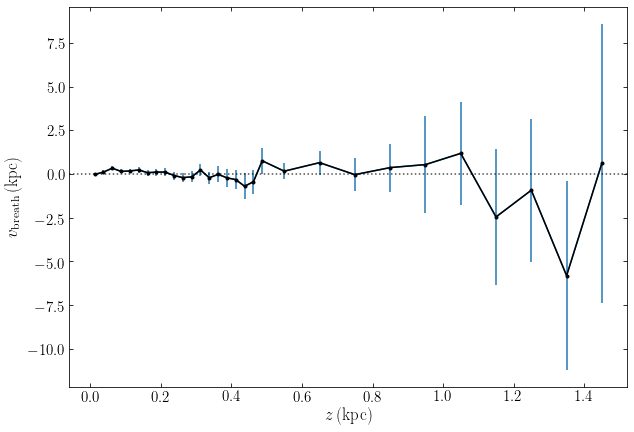

In [94]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(10,7)

mid= (bins[1:]+bins[:-1])/2.
errorbar(mid[mid>0.],((vave_b-vave_b[::-1])/2.)[mid>0.],sqrt(sig_b**2+sig_b[::-1]**2)[mid>0],zorder=0)
plot(mid[mid>0.],((vave_b-vave_b[::-1])/2.)[mid>0.],'k',marker='.',ls='-',zorder=10)
axhline(0.,color='k',ls=':',alpha=0.7)
xlabel(r'$z\,\mathrm{(kpc)}$')
ylabel(r'$v_\mathrm{breath}\,\mathrm{(kpc)}$')
savefig('breath.png')

print(bootstrap((vave_b-vave_b[::-1])/2.,10000))

Plot Figure 2 from the paper by combining the colour-magnitude information from all three samples:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log



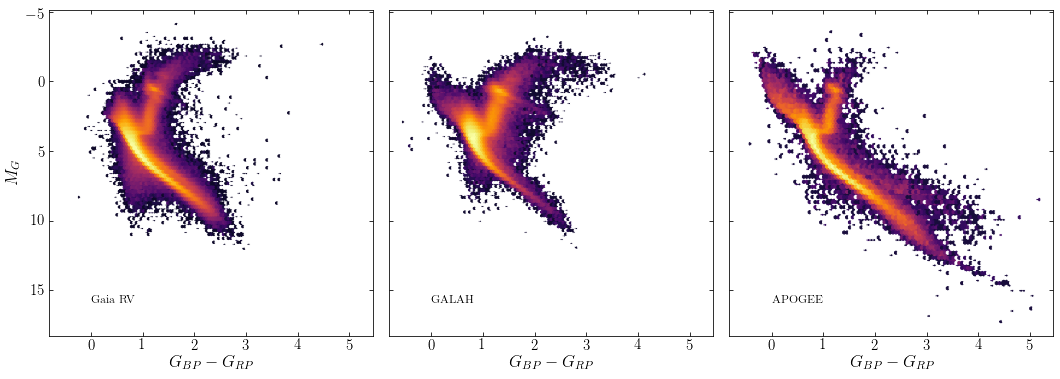

In [46]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(18,6)
colors = np.vstack(([1.,1.,1.,1.], plt.cm.inferno(np.linspace(0, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

fig,(ax1,ax2,ax3) = subplots(1,3,sharey=True,sharex=True)
fig.subplots_adjust(wspace=0.05)

ax1.text(0,16,r'$\mathrm{Gaia\,\,RV}$')
ax2.text(0,16,r'$\mathrm{GALAH}$')
ax3.text(0,16,r'$\mathrm{APOGEE}$')

MGGG= -5*log(1000/gaia2_matches['parallax'])/log(10)+5+gaia2_matches['phot_g_mean_mag']
ax2.hexbin(gaia2_matches['bp_rp'][indx_g],MGGG[indx_g],bins='log',cmap=cmap)
ax2.invert_yaxis()

MGA= -5*log(1000/apgaia2_matches['parallax'])/log(10)+5+apgaia2_matches['phot_g_mean_mag']
ax3.hexbin(apgaia2_matches['bp_rp'][indx_a],MGA[indx_a],bins='log',cmap=cmap)
ax3.invert_yaxis()

MGG= -5*log(1000/out['parallax'])/log(10)+5+out['phot_g_mean_mag']
ax1.hexbin(out['bp_rp'][indx],MGG[indx],bins='log',cmap=cmap)
ax1.invert_yaxis()

ax1.set_xlabel(r'$G_{BP}-G_{RP}$')
ax2.set_xlabel(r'$G_{BP}-G_{RP}$')
ax3.set_xlabel(r'$G_{BP}-G_{RP}$')
ax1.set_ylabel(r'$M_G$')

savefig('CMD_vel.pdf',bbox_inches='tight')

Produce Figure 6 from the paper by combine the median vertical velocities for all three samples:

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)

/Users/Wilhelm/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)



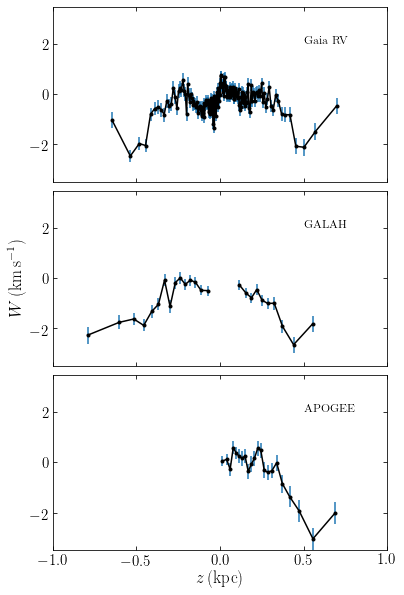

In [96]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,10)

fig, (ax1,ax2,ax3)= subplots(3,sharex=True)
fig.subplots_adjust(hspace=0.05)

ax1.text(0.5,2,r'$\mathrm{Gaia\,\,RV}$')
ax2.text(0.5,2,r'$\mathrm{GALAH}$')
ax3.text(0.5,2,r'$\mathrm{APOGEE}$')

ax2.plot(XYZ_g[indx_g,2][sindx_g][::showskip_g]+0.0209,running_median_galah[::showskip_g],'k.-')
ax2.errorbar(XYZ_g[indx_g,2][sindx_g][::showskip_g]+0.0209,numpy.array(running_median_galah[::showskip_g]),
         yerr=numpy.array(running_median_err_galah[::showskip_g]),
         marker='None',ls='None')

z_a=XYZ_a[indx_a,2][sindx_a][::showskip_a]+0.0209
ax3.plot(z_a[z_a>0][:-1],running_median_apogee[::showskip_a][z_a>0][:-1],'k.-')                    
ax3.errorbar(z_a[z_a>0][:-1],numpy.array(running_median_apogee[::showskip_a][z_a>0])[:-1],
         yerr=numpy.array(running_median_err_apogee[::showskip_a][z_a>0][:-1]),
         marker='None',ls='None')

ax1.plot(XYZ[indx,2][sindx][::showskip][1:]+0.0209,running_median_gaia[::showskip][1:],'k.-')
ax1.errorbar(XYZ[indx,2][sindx][::showskip]+0.0209,numpy.array(running_median_gaia[::showskip]),
         yerr=numpy.array(running_median_err_gaia[::showskip]),
         marker='None',ls='None')
ax3.set_xlim([-1.,1.])
ax3.set_xlabel(r'$z\,(\mathrm{kpc})$')
ax2.set_ylabel(r'$W\,(\mathrm{km\,s}^{-1})$')

for a in [ax1,ax2,ax3]:
    a.set_ylim([-3.5,3.5])
    a.set_yticks([-2,0,2])
    
savefig('3vel.pdf',bbox_inches='tight')